In [17]:
import os, logging, random, gc, time, warnings
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, f1_score

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics, callbacks
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import CSVLogger

from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.ERROR)

# Check the TensorFlow version and GPU availability
print(f"TensorFlow version: {tf.__version__}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.19.0
Num GPUs Available: 1


In [18]:
class CFG:
    seed = 42
    debug = False
    print_freq = 100
    num_workers = 1

    # Project root
    PROJECT_ROOT_DIR = Path.cwd().parents[2]

    OUTPUT_DIR = PROJECT_ROOT_DIR / 'data/working/'
    SPECTROGRAMS_DIR = OUTPUT_DIR / 'birdclef25-mel-spectrograms/'
    
    train_data_dir = PROJECT_ROOT_DIR / 'data/raw/train_audio'
    train_csv = PROJECT_ROOT_DIR / 'data/raw/train.csv'
    taxonomy_csv = PROJECT_ROOT_DIR / 'data/raw/taxonomy.csv'
    working_df_path = PROJECT_ROOT_DIR / 'configs/work_df_w_split_info.csv'

    # Define subfolders in OUTPUT_DIR
    MODELS_DIR = OUTPUT_DIR / 'models'
    PLOTS_DIR = OUTPUT_DIR / 'plots'
    RESULTS_CSV_DIR = OUTPUT_DIR / 'result_csvs'

    # Create directories if they don't exist
    os.makedirs(MODELS_DIR, exist_ok=True)
    os.makedirs(PLOTS_DIR, exist_ok=True)
    os.makedirs(RESULTS_CSV_DIR, exist_ok=True)

    # Parametric input dim (32, 64, or 256)
    # This would be used to also control the input path and shape (see below)
    input_dim = 32 # Default to 32
    
    # Derived paths and shapes
    @property
    def spectrogram_npy(self):
        return self.SPECTROGRAMS_DIR / f'birdclef2025_melspec_5sec_{self.input_dim}_{self.input_dim}.npy'
    
    @property  # Add this to make it dynamic
    def TARGET_SHAPE(self):
        return (self.input_dim, self.input_dim)
    
    in_channels = 1  # Single channel
    LOAD_DATA = True # Load data from precomputed spectrograms
    num_classes = 4  # 4 high-level classes

    epochs = 10
    batch_size = 128
    
    n_fold = 4
    selected_folds = [0,1,2,3]  # Use all folds by default

    lr = 5e-4 
    weight_decay = 1e-5
    min_lr = 1e-6
    
    use_augmentation = False  # Toggle augmentation on/off
    use_oversampling = False # Toggle oversampling on/off
    use_class_weights = False # Toggle class weights on/off

    # Augmentation params
    aug_prob = 0.5 if use_augmentation else 0.0  # Probability of applying any augmentation
    mixup_alpha = 0.2 if use_augmentation else 0.0  # MixUp alpha (beta distribution)
    noise_std = 0.05  # Std dev for Gaussian noise
    max_time_shift = 0.2  # Fraction of time axis to shift (e.g., 20%)
    max_freq_shift = 0.2  # Fraction of freq axis to shift
    max_mask_time = 0.1  # Fraction of time axis to mask
    max_mask_freq = 0.1  # Fraction of freq axis to mask

    # Oversampling params: dict of {class_index: factor} to multiply minority samples
    # e.g., Aim to balance towards Aves (~5530 samples); set factor=0 for majority
    oversampling_factors = {0: 40,  # Amphibia (117 -> ~4680)
                            1: 0,   # Aves (majority, no oversampling)    
                            2: 150, # Insecta (31 -> ~4650)
                            3: 150, # Mammalia (35 -> ~5250)
                            }   
    
    # Derived model save name
    @property
    def model_save_name(self):
        suffix = ""
        if self.use_augmentation:
            suffix += "_aug"
        if self.use_oversampling:
            suffix += "_os"
        if self.use_class_weights:
            suffix += "_cw"
        return f"base_model_{str(self.input_dim)}{suffix}.keras"

    def update_debug_settings(self):
        # Only run 1 fold and 6 epochs in debug mode, we will use this as a quick test
        if self.debug:
            self.epochs = 3
            self.selected_folds = [0]

cfg = CFG()

In [19]:
def add_noise(spec, std):
    noise = tf.random.normal(shape=tf.shape(spec), mean=0.0, stddev=std, dtype=tf.float32)
    return spec + noise

def time_shift(spec, shift_frac):
    shift = int(shift_frac * spec.shape[1])  # Time axis is dim 1
    return tf.roll(spec, shift=shift, axis=1)

def freq_shift(spec, shift_frac):
    shift = int(shift_frac * spec.shape[0])  # Freq axis is dim 0
    return tf.roll(spec, shift=shift, axis=0)

def mask_time(spec, mask_frac):
    mask_len = int(mask_frac * spec.shape[1])
    if mask_len == 0:
        return spec
    start = tf.random.uniform(shape=[], minval=0, maxval=spec.shape[1] - mask_len, dtype=tf.int32)
    mask = tf.zeros((spec.shape[0], mask_len, spec.shape[2]), dtype=spec.dtype)
    spec = tf.concat([spec[:, :start, :], mask, spec[:, start + mask_len:, :]], axis=1)
    return spec

def mask_freq(spec, mask_frac):
    mask_len = int(mask_frac * spec.shape[0])
    if mask_len == 0:
        return spec
    start = tf.random.uniform(shape=[], minval=0, maxval=spec.shape[0] - mask_len, dtype=tf.int32)
    mask = tf.zeros((mask_len, spec.shape[1], spec.shape[2]), dtype=spec.dtype)
    spec = tf.concat([spec[:start, :, :], mask, spec[start + mask_len:, :, :]], axis=0)
    return spec

def mixup(spec1, target1, spec2, target2, alpha):
    lam = np.random.beta(alpha, alpha)
    spec = lam * spec1 + (1 - lam) * spec2
    target = lam * target1 + (1 - lam) * target2
    return spec, target

def data_generator(df, cfg, spectrograms, is_train=True, yield_weight=True):
    """
    Generator function to yield spectrograms and targets for training or evaluation.
    If `is_train` is True, applies augmentations based on cfg settings.
    If `yield_weight` is True, yields sample weights based on class distribution.
    """
    rows = df.to_dict('records')  # List of dicts for easy access
    
    if cfg.use_oversampling and is_train:
        oversampled_rows = []
        for cls, factor in cfg.oversampling_factors.items():
            class_rows = [r for r in rows if r['y_species_encoded'] == cls]
            if factor == 0:  # For majority class (Aves), treat as multiplier=1 (no oversampling)
                multiplier = 1
            else:
                multiplier = factor
            oversampled_rows.extend(class_rows * multiplier)
        random.shuffle(oversampled_rows)  # Shuffle to randomize order
        rows = oversampled_rows

    for idx, row in enumerate(rows):
        samplename = row['samplename']
        spec = spectrograms.get(samplename, np.zeros((*cfg.TARGET_SHAPE, cfg.in_channels), dtype=np.float32))
        spec = np.expand_dims(spec, axis=-1)  # (H, W, 1)
        spec = tf.convert_to_tensor(spec, dtype=tf.float32)  # To TF tensor for ops
        
        target = to_categorical(row['y_species_encoded'], num_classes=cfg.num_classes)
        
        if is_train and cfg.use_augmentation and np.random.rand() < cfg.aug_prob:
            # Apply random augmentations
            if np.random.rand() < 0.5:  # 50% chance each
                spec = add_noise(spec, cfg.noise_std)
            if np.random.rand() < 0.5:
                spec = time_shift(spec, cfg.max_time_shift)
            if np.random.rand() < 0.5:
                spec = freq_shift(spec, cfg.max_freq_shift)
            if np.random.rand() < 0.5:
                spec = mask_time(spec, cfg.max_mask_time)
            if np.random.rand() < 0.5:
                spec = mask_freq(spec, cfg.max_mask_freq)
            
            # MixUp (requires another random sample)
            if cfg.mixup_alpha > 0 and np.random.rand() < 0.5:
                other_idx = np.random.randint(0, len(rows))
                other_row = rows[other_idx]
                other_spec = spectrograms.get(other_row['samplename'], np.zeros_like(spec))
                other_spec = tf.convert_to_tensor(np.expand_dims(other_spec, axis=-1), dtype=tf.float32)
                other_target = to_categorical(other_row['y_species_encoded'], num_classes=cfg.num_classes)
                spec, target = mixup(spec, target, other_spec, other_target, cfg.mixup_alpha)
        
        spec = spec.numpy()  # Back to numpy if needed for yield
        
        if yield_weight:
            sample_weight = class_weights[row['y_species_encoded']]  # Use original class for weight
            yield spec, target, sample_weight
        else:
            yield spec, target

In [20]:
print("\nLoading combined train data...")
full_df = pd.read_csv(cfg.working_df_path)

# Combine train and val as "combined train"
combined_train_val_df = full_df[full_df['split'].isin(['train', 'val'])].reset_index(drop=True)

combined_train_val_df.head()


Loading combined train data...


,primary_label,rating,filename,target,filepath,samplename,class,y_species_encoded,split
0,1139490,0.0,1139490/CSA36389.ogg,0,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1139490-CSA36389,Insecta,2,train
1,1192948,0.0,1192948/CSA36358.ogg,1,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1192948-CSA36358,Insecta,2,train
2,1192948,0.0,1192948/CSA36366.ogg,1,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1192948-CSA36366,Insecta,2,train
3,1192948,0.0,1192948/CSA36373.ogg,1,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1192948-CSA36373,Insecta,2,val
4,1194042,0.0,1194042/CSA18783.ogg,2,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1194042-CSA18783,Insecta,2,val


In [21]:
# Load pre-computed mel spectrograms
spectrograms = np.load(cfg.spectrogram_npy, allow_pickle=True).item()
print(f"Loaded {len(spectrograms)} pre-computed mel spectrograms")
print(f"Example spectrogram shape: {spectrograms['1139490-CSA36389'].shape}")

# This is a dict, the samplename '1139490-CSA36389' is the key
spectrograms['1139490-CSA36389']

Loaded 28564 pre-computed mel spectrograms
Example spectrogram shape: (32, 32)


array([[0.60927516, 0.82787275, 0.8543863 , ..., 0.5926887 , 0.8844918 ,
        0.7155297 ],
       [0.619291  , 0.89863867, 0.7358351 , ..., 0.60509133, 0.86708546,
        0.6459563 ],
       [0.53857917, 0.6364324 , 0.7601948 , ..., 0.54124737, 0.7848017 ,
        0.66509414],
       ...,
       [0.2903521 , 0.21302953, 0.23228   , ..., 0.24894655, 0.1931243 ,
        0.2143865 ],
       [0.2715999 , 0.22699611, 0.22744066, ..., 0.21395011, 0.23434846,
        0.22203825],
       [0.23533896, 0.2204537 , 0.20143878, ..., 0.23799029, 0.22495545,
        0.21065843]], dtype=float32)

In [22]:
# Custom class weights based on the distribution in the combined train/val set
@tf.keras.utils.register_keras_serializable()
class AddClsToken(tf.keras.layers.Layer):
    def __init__(self, projection_dim, **kwargs):
        super(AddClsToken, self).__init__(**kwargs)
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.cls_token = self.add_weight(
            shape=(1, 1, self.projection_dim),
            initializer="zeros",
            trainable=True,
            name="cls_token"
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        cls = tf.tile(self.cls_token, [batch_size, 1, 1])
        return tf.concat([cls, inputs], axis=1)

    def get_config(self):
        config = super(AddClsToken, self).get_config()
        config.update({"projection_dim": self.projection_dim})
        return config

@tf.keras.utils.register_keras_serializable()
def macro_f1_fn(y_true, y_pred):
    """Pure TensorFlow macro F1 implementation"""
    y_true_labels = tf.argmax(y_true, axis=-1)
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    
    num_classes = tf.shape(y_true)[-1]
    f1_scores = []
    
    for class_id in range(4):  # Use your num_classes=4
        true_class = tf.equal(y_true_labels, class_id)
        pred_class = tf.equal(y_pred_labels, class_id)
        
        tp = tf.reduce_sum(tf.cast(tf.logical_and(true_class, pred_class), tf.float32))
        fp = tf.reduce_sum(tf.cast(tf.logical_and(tf.logical_not(true_class), pred_class), tf.float32))
        fn = tf.reduce_sum(tf.cast(tf.logical_and(true_class, tf.logical_not(pred_class)), tf.float32))
        
        precision = tp / (tp + fp + tf.keras.backend.epsilon())
        recall = tp / (tp + fn + tf.keras.backend.epsilon())
        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        
        f1_scores.append(f1)
    
    return tf.reduce_mean(tf.stack(f1_scores))

In [23]:
def get_vit_model(cfg):
    input_shape = (*cfg.TARGET_SHAPE, cfg.in_channels)  # (32,32,1) or similar
    inputs = layers.Input(shape=input_shape)

    # Patch + Embed (conv stem)
    patch_size = 4
    projection_dim = 128  # Increased
    num_patches = (cfg.input_dim // patch_size) ** 2  # 64 for input_dim=32, etc.

    x = layers.Conv2D(filters=projection_dim, kernel_size=patch_size, strides=patch_size, padding="valid")(inputs)
    x = layers.Reshape((num_patches, projection_dim))(x)

    # Add class token using the custom layer
    x = AddClsToken(projection_dim=projection_dim)(x)

    # Positional embeddings (for num_patches + 1 positions)
    positions = tf.range(start=0, limit=num_patches + 1, delta=1)
    pos_embed = layers.Embedding(input_dim=num_patches + 1, output_dim=projection_dim)(positions)
    x = x + pos_embed

    # Transformer encoders
    num_blocks = 6  # Increased
    num_heads = 8   # Increased
    mlp_dim = 256   # Increased

    for _ in range(num_blocks):
        y = layers.LayerNormalization(epsilon=1e-6)(x)
        y = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim // num_heads, dropout=0.2)(y, y)
        x = layers.Add()([x, y])

        y = layers.LayerNormalization(epsilon=1e-6)(x)
        y = layers.Dense(mlp_dim, activation='gelu')(y)
        y = layers.Dropout(0.2)(y)
        y = layers.Dense(projection_dim)(y)
        x = layers.Add()([x, y])

    # Head: Use class token instead of GAP
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = x[:, 0, :]  # Extract cls_token
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(cfg.num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)

    return model

# # Chekc the model struture
# test_model = get_vit_model(cfg)

# test_model.compile(
#     optimizer = tf.keras.optimizers.AdamW(cfg.lr, weight_decay=cfg.weight_decay),
#     loss      = tf.keras.losses.CategoricalFocalCrossentropy(gamma=2.0, alpha=0.25),
#     metrics   = [
#         "accuracy",
#         tf.keras.metrics.AUC(name="auc"),
#         tf.keras.metrics.AUC(curve="PR", name="pr_auc"),
#         macro_f1_fn,                    # your custom metric
#     ],
# )

# # Get the model summary
# test_model.summary()

# # Clean up
# del test_model
# gc.collect()

In [24]:
# Sanity check: Print class counts across full dataset
class_counts = combined_train_val_df['y_species_encoded'].value_counts().sort_index()
print("Full dataset class distribution (0: Amphibia, 1: Aves, 2: Insecta, 3: Mammalia):")
print(class_counts)
print(f"Imbalance ratio: Aves / Total = {class_counts[1] / class_counts.sum():.2%}")

# Create class mapping dictionary
class_mapping_dict = {
    0: 'Amphibia',
    1: 'Aves',
    2: 'Insecta',
    3: 'Mammalia'
}

# Sanity check 2: Inspect a batch from the generator
gen = data_generator(combined_train_val_df[combined_train_val_df['split'] == 'train'], cfg, spectrograms, is_train=True, yield_weight=False)
batch_specs, batch_labels = next(gen)  # Get one item (since generator is per-sample)
print("\nExample batch label (one-hot):", batch_labels)
print("Class order matches Dense layer: [Amphibia, Aves, Insecta, Mammalia]")

# Create class weights for imbalanced dataset
classes = np.unique(combined_train_val_df['y_species_encoded'])
labels = combined_train_val_df['y_species_encoded'].values

if cfg.use_class_weights:
    print("\nComputing class weights...")
    class_weights = compute_class_weight('balanced', classes=classes, y=labels)
    class_weights_dict = dict(zip(classes, class_weights))
    print("Computed class weights:", class_weights_dict)
else:
    print("\nUsing uniform class weights")
    class_weights_dict = {i: 1.0 for i in range(cfg.num_classes)}  # Uniform weights when toggled off
    


Full dataset class distribution (0: Amphibia, 1: Aves, 2: Insecta, 3: Mammalia):
y_species_encoded
0      466
1    22118
2      124
3      143
Name: count, dtype: int64
Imbalance ratio: Aves / Total = 96.79%

Example batch label (one-hot): [0. 0. 1. 0.]
Class order matches Dense layer: [Amphibia, Aves, Insecta, Mammalia]

Using uniform class weights


In [25]:
def make_ds(df, is_train, with_weight=True):
    sig = (
        tf.TensorSpec((*cfg.TARGET_SHAPE, cfg.in_channels), tf.float32),
        tf.TensorSpec((cfg.num_classes,), tf.float32),
    )
    if with_weight:
        sig += (tf.TensorSpec((), tf.float32),)

    gen = lambda: data_generator(df, cfg, spectrograms,
                                 is_train=is_train, yield_weight=with_weight)

    return tf.data.Dataset.from_generator(gen, output_signature=sig) \
             .shuffle(10_000 if is_train else 1) \
             .prefetch(tf.data.AUTOTUNE)   

In [26]:
class_weights_dict

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}

In [27]:
cfg.model_save_name

'base_model_32.keras'

In [28]:
# Simple 80/20 stratified split
train_df, val_df = train_test_split(
    combined_train_val_df, 
    test_size=0.2, 
    stratify=combined_train_val_df['y_species_encoded'],
    random_state=cfg.seed
)

print(f"Train size: {len(train_df)}, Val size: {len(val_df)}")


# 1) build TRAIN / VAL datasets *without* sample weights
train_ds = make_ds(train_df, is_train=True,  with_weight=False)
val_ds   = make_ds(val_df,   is_train=False, with_weight=False)

# 2) (optional) keep a larger shuffle + batch here if you like
train_ds = train_ds.shuffle(buffer_size=len(train_df))\
                   .batch(cfg.batch_size)\
                   .prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(cfg.batch_size).prefetch(tf.data.AUTOTUNE)

model = get_vit_model(cfg)

model.compile(
    optimizer = tf.keras.optimizers.AdamW(cfg.lr, weight_decay=cfg.weight_decay),
    loss      = tf.keras.losses.CategoricalFocalCrossentropy(gamma=2.0, alpha=0.25),
    metrics   = [
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.AUC(curve="PR", name="pr_auc"),
        macro_f1_fn,                    # your custom metric
    ],
)

# Callbacks
cb_list = []

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras", 
    monitor='val_macro_f1', 
    mode='max', 
    save_best_only=True,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_macro_f1',
    mode='max',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_macro_f1',
    mode='max',
    factor=0.5,
    patience=2,
    min_lr=cfg.min_lr,
    verbose=1
)

log_csv_path = cfg.RESULTS_CSV_DIR / f"training_log_{cfg.input_dim}{cfg.model_save_name.replace('base_model_', '').replace('.keras', '')}.csv"
csv_logger = tf.keras.callbacks.CSVLogger(log_csv_path, append=True, separator=',')

cb_list = [model_checkpoint, early_stopping, csv_logger]

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs          = cfg.epochs,
    class_weight    = class_weights_dict,
    callbacks       = cb_list,
)

# Save the model
model_save_path = cfg.MODELS_DIR / cfg.model_save_name
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

Train size: 18280, Val size: 4571


Epoch 1/10


2025-07-29 17:12:12.505815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9744 of 10000
2025-07-29 17:12:12.783689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-29 17:12:22.178529: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
I0000 00:00:1753834342.182845  251362 service.cc:152] XLA service 0x762f68010b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753834342.182932  251362 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-07-29 17:12:22.712146: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753834344.940980  251362 cuda_dnn.cc:529] Loaded cuDNN version 90300


      2/Unknown 51s 51ms/step - accuracy: 0.5664 - auc: 0.8086 - loss: 0.1753 - macro_f1_fn: 0.1854 - pr_auc: 0.6218

I0000 00:00:1753834358.522631  251362 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    143/Unknown 70s 135ms/step - accuracy: 0.9417 - auc: 0.9772 - loss: 0.0402 - macro_f1_fn: 0.2420 - pr_auc: 0.9443

2025-07-29 17:12:57.763703: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-07-29 17:12:57.763835: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-07-29 17:13:10.710740: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 229ms/step - accuracy: 0.9418 - auc: 0.9772 - loss: 0.0401 - macro_f1_fn: 0.2421 - pr_auc: 0.9444 - val_accuracy: 0.9678 - val_auc: 0.9837 - val_loss: 0.0214 - val_macro_f1_fn: 0.2459 - val_pr_auc: 0.9560
Epoch 2/10


2025-07-29 17:13:21.144908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8616 of 10000
2025-07-29 17:13:22.780151: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


  5/143 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9699 - auc: 0.9883 - loss: 0.0169 - macro_f1_fn: 0.2462 - pr_auc: 0.9661

2025-07-29 17:13:30.550466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9671 - auc: 0.9836 - loss: 0.0216 - macro_f1_fn: 0.2458 - pr_auc: 0.9542

2025-07-29 17:13:39.896514: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 68ms/step - accuracy: 0.9671 - auc: 0.9836 - loss: 0.0216 - macro_f1_fn: 0.2458 - pr_auc: 0.9542 - val_accuracy: 0.9678 - val_auc: 0.9841 - val_loss: 0.0194 - val_macro_f1_fn: 0.2459 - val_pr_auc: 0.9594
Epoch 3/10


2025-07-29 17:13:50.288256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8869 of 10000
2025-07-29 17:13:51.368109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


  3/143 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9549 - auc: 0.9759 - loss: 0.0270 - macro_f1_fn: 0.2442 - pr_auc: 0.9319  

2025-07-29 17:14:00.287697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 8233 of 18280
2025-07-29 17:14:00.354715: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 75ms/step - accuracy: 0.9683 - auc: 0.9839 - loss: 0.0202 - macro_f1_fn: 0.2460 - pr_auc: 0.9558 - val_accuracy: 0.9678 - val_auc: 0.9846 - val_loss: 0.0198 - val_macro_f1_fn: 0.2459 - val_pr_auc: 0.9612
Epoch 4/10


2025-07-29 17:14:21.043900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8300 of 10000
2025-07-29 17:14:23.034137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-29 17:14:31.044050: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 7229 of 18280


  5/143 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9771 - auc: 0.9860 - loss: 0.0191 - macro_f1_fn: 0.2471 - pr_auc: 0.9666

2025-07-29 17:14:32.119526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9699 - auc: 0.9843 - loss: 0.0194 - macro_f1_fn: 0.2462 - pr_auc: 0.9568

2025-07-29 17:14:41.236898: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-07-29 17:14:41.236941: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12920995682541731227
2025-07-29 17:14:41.236971: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11599498545891412100


143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 67ms/step - accuracy: 0.9699 - auc: 0.9843 - loss: 0.0194 - macro_f1_fn: 0.2462 - pr_auc: 0.9567 - val_accuracy: 0.9678 - val_auc: 0.9858 - val_loss: 0.0189 - val_macro_f1_fn: 0.2459 - val_pr_auc: 0.9668
Epoch 5/10


2025-07-29 17:14:51.645390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6785 of 10000
2025-07-29 17:14:55.756415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-29 17:15:01.645636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 4668 of 18280


  1/143 ━━━━━━━━━━━━━━━━━━━━ 58:19 25s/step - accuracy: 0.9531 - auc: 0.9860 - loss: 0.0218 - macro_f1_fn: 0.2440 - pr_auc: 0.9592

2025-07-29 17:15:06.123293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - accuracy: 0.9665 - auc: 0.9835 - loss: 0.0205 - macro_f1_fn: 0.2457 - pr_auc: 0.9576 - val_accuracy: 0.9678 - val_auc: 0.9858 - val_loss: 0.0193 - val_macro_f1_fn: 0.2459 - val_pr_auc: 0.9682
Epoch 6/10


2025-07-29 17:15:25.863406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9029 of 10000
2025-07-29 17:15:26.769808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


  3/143 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9735 - auc: 0.9903 - loss: 0.0149 - macro_f1_fn: 0.2466 - pr_auc: 0.9726  

2025-07-29 17:15:34.914406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - accuracy: 0.9686 - auc: 0.9849 - loss: 0.0192 - macro_f1_fn: 0.2460 - pr_auc: 0.9604 - val_accuracy: 0.9678 - val_auc: 0.9866 - val_loss: 0.0192 - val_macro_f1_fn: 0.2459 - val_pr_auc: 0.9689
Epoch 7/10


2025-07-29 17:15:57.006056: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9224 of 10000
2025-07-29 17:15:57.812227: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


  5/143 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9623 - auc: 0.9793 - loss: 0.0246 - macro_f1_fn: 0.2452 - pr_auc: 0.9574

2025-07-29 17:16:06.715068: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9663 - auc: 0.9829 - loss: 0.0208 - macro_f1_fn: 0.2457 - pr_auc: 0.9563

2025-07-29 17:16:16.846746: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12920995682541731227
2025-07-29 17:16:16.846805: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11599498545891412100


143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 74ms/step - accuracy: 0.9663 - auc: 0.9829 - loss: 0.0208 - macro_f1_fn: 0.2457 - pr_auc: 0.9564 - val_accuracy: 0.9678 - val_auc: 0.9865 - val_loss: 0.0187 - val_macro_f1_fn: 0.2459 - val_pr_auc: 0.9695
Epoch 8/10


2025-07-29 17:16:27.285863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7467 of 10000
2025-07-29 17:16:31.456659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


  3/143 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9701 - auc: 0.9868 - loss: 0.0178 - macro_f1_fn: 0.2462 - pr_auc: 0.9565  

2025-07-29 17:16:40.785000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9678 - auc: 0.9851 - loss: 0.0192 - macro_f1_fn: 0.2459 - pr_auc: 0.9616

2025-07-29 17:16:51.215228: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.9678 - auc: 0.9851 - loss: 0.0192 - macro_f1_fn: 0.2459 - pr_auc: 0.9616 - val_accuracy: 0.9678 - val_auc: 0.9859 - val_loss: 0.0187 - val_macro_f1_fn: 0.2459 - val_pr_auc: 0.9665
Epoch 9/10


2025-07-29 17:17:01.604453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 597 of 18280


  5/143 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9772 - auc: 0.9928 - loss: 0.0122 - macro_f1_fn: 0.2471 - pr_auc: 0.9781

2025-07-29 17:17:11.396264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9704 - auc: 0.9866 - loss: 0.0178 - macro_f1_fn: 0.2462 - pr_auc: 0.9675

2025-07-29 17:17:22.132925: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11599498545891412100


143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.9704 - auc: 0.9866 - loss: 0.0178 - macro_f1_fn: 0.2462 - pr_auc: 0.9675 - val_accuracy: 0.9678 - val_auc: 0.9864 - val_loss: 0.0190 - val_macro_f1_fn: 0.2459 - val_pr_auc: 0.9690
Epoch 10/10


2025-07-29 17:17:32.780559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4962 of 10000
2025-07-29 17:17:44.489013: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-29 17:17:44.489125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 1 of 18280


  5/143 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9856 - auc: 0.9929 - loss: 0.0123 - macro_f1_fn: 0.2482 - pr_auc: 0.9842  

2025-07-29 17:17:53.464189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9682 - auc: 0.9848 - loss: 0.0196 - macro_f1_fn: 0.2459 - pr_auc: 0.9628

2025-07-29 17:18:03.090305: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12920995682541731227
2025-07-29 17:18:03.090365: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11599498545891412100


143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.9682 - auc: 0.9848 - loss: 0.0196 - macro_f1_fn: 0.2459 - pr_auc: 0.9628 - val_accuracy: 0.9678 - val_auc: 0.9873 - val_loss: 0.0185 - val_macro_f1_fn: 0.2459 - val_pr_auc: 0.9710
Model saved to: /home/tealeave/projects/mids-207/DATASCI207_Bird_Sounds/data/working/models/base_model_32.keras


In [29]:
def evaluate_on_test(model, cfg, spectrograms, test_df):
    """
    Evaluate the model on the test dataset.
    
    Parameters:
    -----------
    model: Trained Keras model
    cfg: Configuration object with attributes like TARGET_SHAPE, in_channels, num_classes, batch_size
    spectrograms: Dictionary of precomputed spectrograms
    test_df: DataFrame with test samples
    
    Returns:
    --------
    y_true: One-hot encoded true labels (numpy array)
    y_pred: Predicted probabilities (numpy array)
    """
    # Create test dataset (no augmentation, no weights)
    test_ds = tf.data.Dataset.from_generator(
        lambda: data_generator(test_df, cfg, spectrograms, is_train=False, yield_weight=False),
        output_signature=(
            tf.TensorSpec(shape=(*cfg.TARGET_SHAPE, cfg.in_channels), dtype=tf.float32),
            tf.TensorSpec(shape=(cfg.num_classes,), dtype=tf.float32)
        )
    )
    test_ds = test_ds.batch(cfg.batch_size).prefetch(tf.data.AUTOTUNE)
    
    # Ground truth labels (one-hot encoded)
    y_true = np.array([to_categorical(row['y_species_encoded'], num_classes=cfg.num_classes) 
                       for _, row in test_df.iterrows()])
    
    # Get predictions
    y_pred = model.predict(test_ds, verbose=1)
    
    # Clear session and collect garbage
    tf.keras.backend.clear_session()
    gc.collect()
    
    # Compute overall metrics
    test_loss = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred).numpy()
    test_auc = tf.keras.metrics.AUC(multi_label=False)(y_true, y_pred).numpy()
    test_acc = tf.keras.metrics.CategoricalAccuracy()(y_true, y_pred).numpy()
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    
    return y_true, y_pred

def plot_test_evaluation(y_true, y_pred, class_mapping=None, cfg=None):
    """
    Plot confusion matrix, probability distributions, and print classification report for test evaluation.
    
    Parameters:
    -----------
    y_true: One-hot encoded true labels (numpy array)
    y_pred: Predicted probabilities (numpy array)
    class_mapping: dict mapping class indices to names (e.g., {0: 'Amphibia', 1: 'Aves'})
    cfg: Configuration object with RESULTS_CSV_DIR, input_dim, model_save_name
    """
    # Default mapping if none provided
    if class_mapping is None:
        class_mapping = {i: f'Class_{i}' for i in range(y_true.shape[1])}
    
    # Get class names in order
    class_names = [class_mapping[i] for i in range(len(class_mapping))]
    
    # Convert to class labels
    y_true_labels = np.argmax(y_true, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Confusion Matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    im = axes[0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[0].figure.colorbar(im, ax=axes[0])
    axes[0].set(xticks=np.arange(cm.shape[1]),
                yticks=np.arange(cm.shape[0]),
                xticklabels=class_names, 
                yticklabels=class_names,
                title='Confusion Matrix',
                ylabel='True label',
                xlabel='Predicted label')
    
    # Rotate x-tick labels
    plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add text annotations to CM
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[0].text(j, i, format(cm[i, j], 'd'),
                         ha="center", va="center",
                         color="white" if cm[i, j] > thresh else "black")
    
    # Plot 2: Per-class probability distributions
    for idx, class_name in enumerate(class_names):
        axes[1].hist(y_pred[:, idx], bins=30, alpha=0.5, label=class_name)
    axes[1].set_xlabel('Predicted Probability')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Distribution of Predicted Probabilities by Class')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Save classification report as CSV if cfg is provided
    report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    if cfg is not None:
        suffix = cfg.model_save_name.replace('base_model_', '').replace('.keras', '')
        csv_path = cfg.RESULTS_CSV_DIR / f"classification_report_{cfg.input_dim}{suffix}.csv"
        df_report.to_csv(csv_path)
        print(f"Classification report saved to: {csv_path}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

def plot_training_diagnostics(history, cfg, y_true, y_pred, class_mapping_dict):
    """
    Plot training diagnostics: learning curves, normalized confusion matrix, and per-class metrics bar plot.
    Saves plots to disk after displaying.
    
    Parameters:
    -----------
    history: Keras history object from model.fit()
    cfg: Configuration object with PLOTS_DIR, input_dim, model_save_name
    y_true: One-hot encoded true labels (numpy array)
    y_pred: Predicted probabilities (numpy array)
    class_mapping_dict: dict mapping class indices to names
    """
    # Combined Learning Curves
    metrics_to_plot = ['loss', 'macro_f1_fn', 'pr_auc', 'auc', 'accuracy', 'f1']
    fig, axs = plt.subplots(3, 2, figsize=(12, 12))
    axs = axs.flatten()
    for i, metric in enumerate(metrics_to_plot):
        if metric in history.history:
            axs[i].plot(history.history[metric], label=f'Train {metric}')
            if f'val_{metric}' in history.history:
                axs[i].plot(history.history[f'val_{metric}'], label=f'Val {metric}')
            axs[i].set_title(f'{metric.capitalize()} Curve')
            axs[i].set_xlabel('Epoch')
            axs[i].set_ylabel(metric.capitalize())
            axs[i].legend()
    plt.tight_layout()
    plt.show()  # Display the combined curves plot
    
    # Save learning curves
    suffix = cfg.model_save_name.replace('base_model_', '').replace('.keras', '')
    plot_path = cfg.PLOTS_DIR / f"training_curves_{cfg.input_dim}{suffix}.png"
    plt.savefig(plot_path)
    plt.close(fig)
    print(f"Training curves saved to: {plot_path}")

    # Convert to class labels for CM and report
    y_true_labels = np.argmax(y_true, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    class_names = list(class_mapping_dict.values())

    # Confusion Matrix (normalized)
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm / np.sum(cm, axis=1)[:, np.newaxis], annot=True, fmt='.2%', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()  # Display the confusion matrix
    
    # Save CM
    cm_plot_path = cfg.PLOTS_DIR / f"confusion_matrix_{cfg.input_dim}{suffix}.png"
    plt.savefig(cm_plot_path)
    plt.close()
    print(f"Confusion matrix saved to: {cm_plot_path}")

    # Per-Class Bar Plot
    report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose().iloc[:-3, :3]  # Precision, Recall, F1 per class
    df_report.plot(kind='bar', figsize=(10, 6))
    plt.title('Per-Class Precision, Recall, F1')
    plt.show()  # Display the per-class metrics plot
    
    # Save per-class metrics
    per_class_plot_path = cfg.PLOTS_DIR / f"per_class_metrics_{cfg.input_dim}{suffix}.png"
    plt.savefig(per_class_plot_path)
    plt.close()
    print(f"Per-class metrics saved to: {per_class_plot_path}")

Test size: 5713
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 266ms/step

Test Loss: 0.2893
Test AUC: 0.9868
Test Accuracy: 0.9680


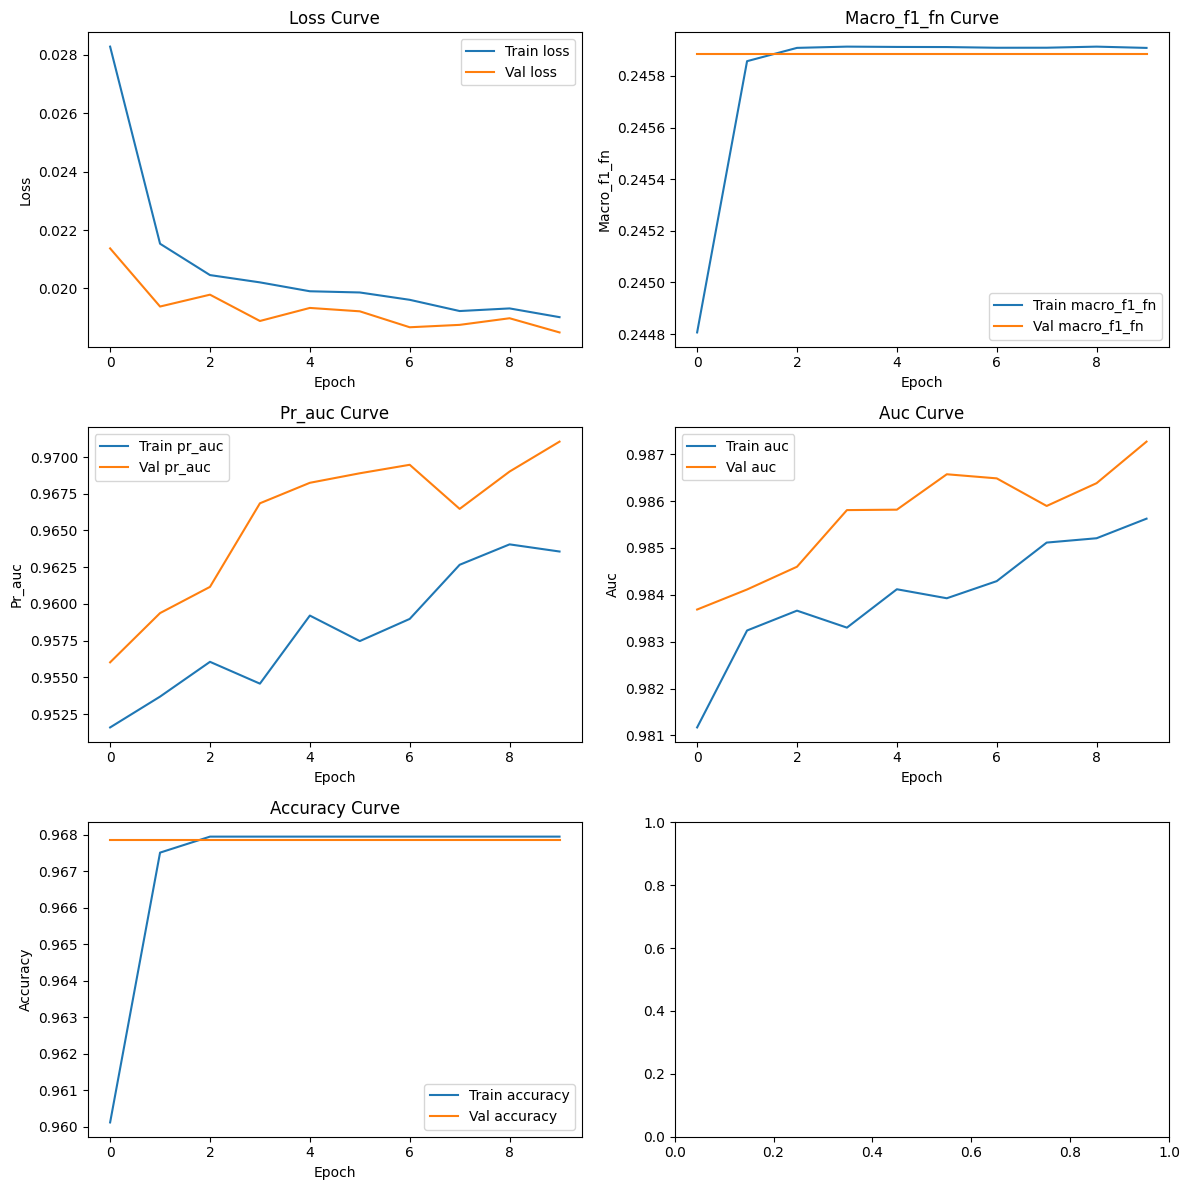

Training curves saved to: /home/tealeave/projects/mids-207/DATASCI207_Bird_Sounds/data/working/plots/training_curves_3232.png


<Figure size 640x480 with 0 Axes>

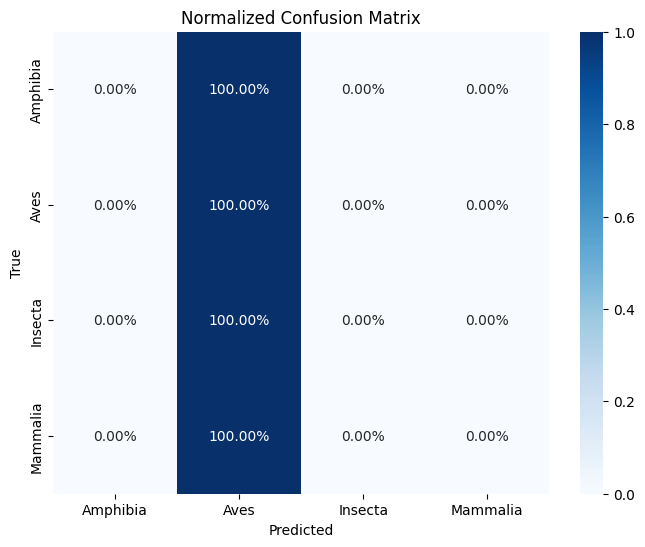

Confusion matrix saved to: /home/tealeave/projects/mids-207/DATASCI207_Bird_Sounds/data/working/plots/confusion_matrix_3232.png


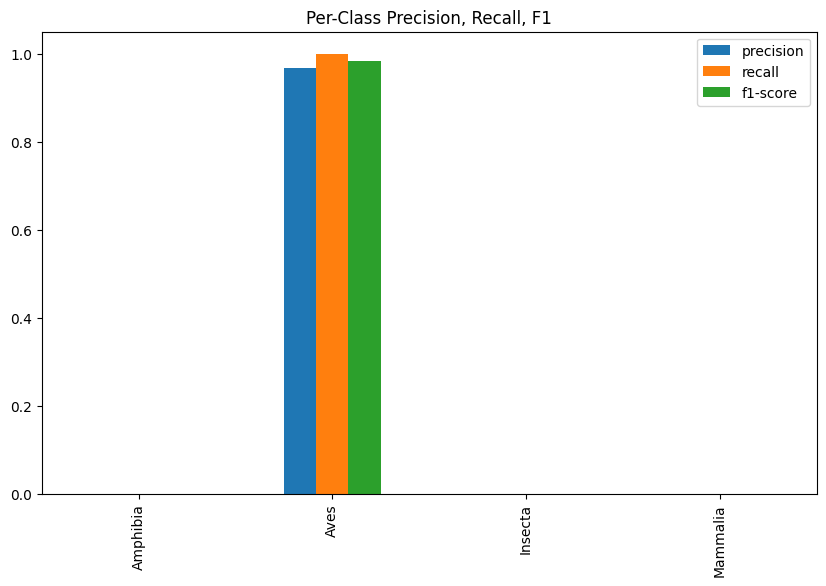

Per-class metrics saved to: /home/tealeave/projects/mids-207/DATASCI207_Bird_Sounds/data/working/plots/per_class_metrics_3232.png


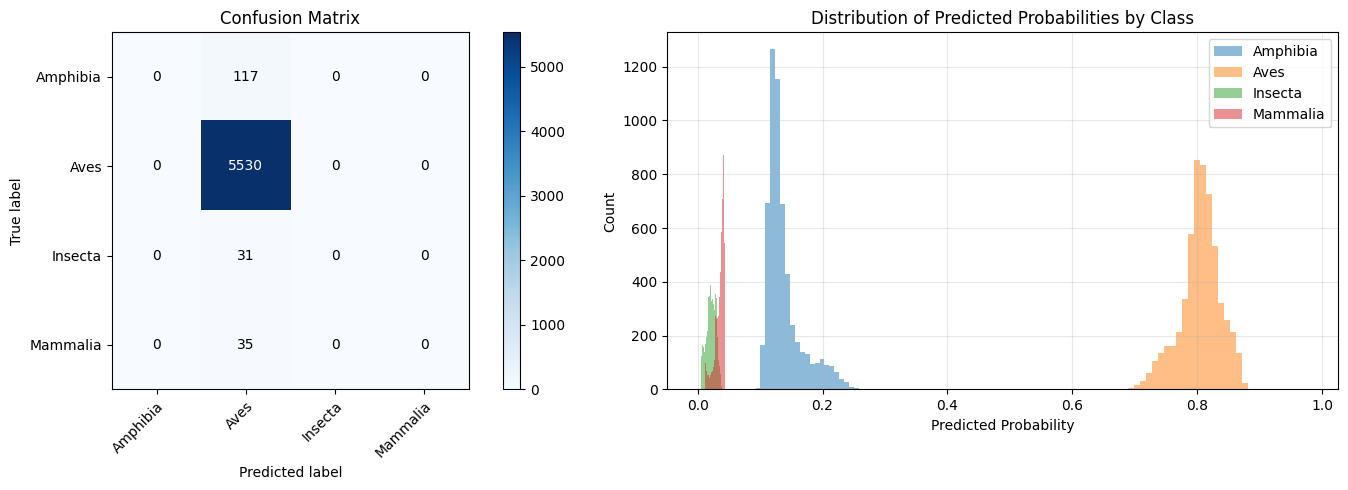

Classification report saved to: /home/tealeave/projects/mids-207/DATASCI207_Bird_Sounds/data/working/result_csvs/classification_report_3232.csv

Classification Report:
              precision    recall  f1-score   support

    Amphibia       0.00      0.00      0.00       117
        Aves       0.97      1.00      0.98      5530
     Insecta       0.00      0.00      0.00        31
    Mammalia       0.00      0.00      0.00        35

    accuracy                           0.97      5713
   macro avg       0.24      0.25      0.25      5713
weighted avg       0.94      0.97      0.95      5713



In [30]:
# Run evaluation
test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)
print(f"Test size: {len(test_df)}")

y_true, y_pred = evaluate_on_test(model, cfg, spectrograms, test_df)

plot_training_diagnostics(history, cfg, y_true, y_pred, class_mapping_dict)

# Plot with dictionary
plot_test_evaluation(y_true, y_pred, class_mapping=class_mapping_dict, cfg=cfg)